In [1]:
# Clone the ibm/tsfm
! git clone https://github.com/IBM/tsfm.git

Cloning into 'tsfm'...
remote: Enumerating objects: 2743, done.
remote: Counting objects: 100% (1290/1290), done.
remote: Compressing objects: 100% (463/463), done.
remote: Total 2743 (delta 884), reused 971 (delta 809), pack-reused 1453 (from 1)
Receiving objects: 100% (2743/2743), 24.56 MiB | 22.97 MiB/s, done.
Resolving deltas: 100% (1629/1629), done.


In [2]:
# Change directory. Move inside the tsfm repo.
%cd tsfm

/content/tsfm


In [3]:
# Install the tsfm library
! pip install ".[notebooks]"

Processing /content/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.5 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB

In [191]:
import math
import os
import tempfile

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import TinyTimeMixerForPrediction, TrackingCallback, count_parameters, load_dataset
from tsfm_public.toolkit.visualization import plot_predictions
import yfinance as yf
import pandas as pd
from datetime import timedelta
from typing import Any, Dict, Generator, List, Optional, Tuple, Union
from datasets import Dataset
from tsfm_public.toolkit.dataset import ForecastDFDataset

In [192]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [273]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

forecast_length=1

target_dataset = '/content/apple_stock_2023_daily_train.csv'
DATA_ROOT_PATH = "/content/"
learning_rate=0.001

ticker = "AAPL"
batch_size=64
# Define the prediction start date and context length
prediction_start_date = pd.to_datetime("2023-04-05")
context_length = 1024
start_train='1900-01-01'
buffer_days = 3 * context_length
data_start_date = prediction_start_date - timedelta(days=buffer_days)

# Fetch the data starting from the calculated start date
data = yf.download(ticker, start=data_start_date.strftime('%Y-%m-%d'), end="2024-01-01")

# Drop missing values to keep only valid data
data_resampled = data.dropna()

# Select only the 'Close' price and reset the index
apple_stock_data = data_resampled[['Close']].reset_index()



# Concatenate the two datasets (before and after)
test_start_date = apple_stock_data[apple_stock_data['Date'] < prediction_start_date].tail(context_length).iloc[0]['Date']
validation_start_date = apple_stock_data[apple_stock_data['Date'] < prediction_start_date].tail(context_length*2+20).iloc[0]['Date']
freeze_backbone=False
num_epochs=50
# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "1024_96_v1"

[*********************100%***********************]  1 of 1 completed


In [274]:

data = yf.download(ticker, start=start_train, end="2024-01-01")

# بازنمونه‌گیری (resample) به صورت روزانه و پر کردن مقادیر گمشده
data_resampled = data.dropna()

# Reset the index to have the timestamp as a column
apple_stock_data = data_resampled[['Close']].reset_index()


[*********************100%***********************]  1 of 1 completed


In [275]:
apple_stock_data

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10848,2023-12-22,193.600006
10849,2023-12-26,193.050003
10850,2023-12-27,193.149994
10851,2023-12-28,193.580002


In [276]:
# Select the relevant columns and rename 'Datetime' to 'timestamp'
apple_stock_data = apple_stock_data[['Date', 'Close']]
apple_stock_data.rename(columns={'Date': 'timestamp', 'Close': 'close'}, inplace=True)

# Normalize the 'close' prices
# apple_stock_data['close'] = (apple_stock_data['close'] - apple_stock_data['close'].mean()) / apple_stock_data['close'].std()

# Save the processed data to a CSV file
apple_stock_data.to_csv('/content/apple_stock_2023_daily_train.csv', index=False)

# Display the first few rows to verify the data
apple_stock_data


,timestamp,close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10848,2023-12-22,193.600006
10849,2023-12-26,193.050003
10850,2023-12-27,193.149994
10851,2023-12-28,193.580002


In [277]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor


In [278]:
len(apple_stock_data),

(10853,)

In [279]:
import pandas as pd

# پارامترها
timestamp_column = "timestamp"
id_columns = []
target_columns = ["close"]


# بارگذاری داده‌ها
data = pd.read_csv(target_dataset, parse_dates=[timestamp_column])

# تفکیک داده‌ها به مجموعه‌های آموزشی و اعتبارسنجی
train_data = data[data[timestamp_column] < validation_start_date]
val_data = data[(data[timestamp_column] >= validation_start_date) & (data[timestamp_column] < test_start_date)]
test_data = data[data[timestamp_column] >= test_start_date]

# Display the data range for each dataset
print(f"Train data range: {train_data[timestamp_column].min()} to {train_data[timestamp_column].max()}")
print(f"Validation data range: {val_data[timestamp_column].min()} to {val_data[timestamp_column].max()}")
print(f"Test data range: {test_data[timestamp_column].min()} to {test_data[timestamp_column].max()}")

# آماده‌سازی داده‌ها با استفاده از پیش‌پردازشگر سری زمانی
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

ts_preprocessor = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    encode_categorical=False,
)


Train data range: 1980-12-12 00:00:00 to 2015-01-15 00:00:00
Validation data range: 2015-01-16 00:00:00 to 2019-03-12 00:00:00
Test data range: 2019-03-13 00:00:00 to 2023-12-29 00:00:00


In [280]:

def get_single_dataset(
    ts_preprocessor: TimeSeriesPreprocessor,
    dataset: Union[Dataset, pd.DataFrame],
    stride: int = 1,
    as_univariate: bool = False,
    use_frequency_token: bool = False,
) -> Any:
    """Creates the preprocessed pytorch dataset for the entire dataset without any splits.

    Args:
        dataset (Union[Dataset, pd.DataFrame]): Loaded pandas dataframe.
        stride (int): Stride used for creating the dataset. Defaults to 1.
        as_univariate (bool, optional): When True the dataset returned will contain only one target column. An
            additional ID is added to distinguish original column name. Only valid if there are no exogenous
            specified. Defaults to False.
        use_frequency_token (bool): If True, dataset is created that includes the frequency token. Defaults to False.

    Returns:
        A pytorch dataset.
    """

    if not ts_preprocessor.context_length:
        raise ValueError("TimeSeriesPreprocessor must be instantiated with non-null context_length")
    if not ts_preprocessor.prediction_length:
        raise ValueError("TimeSeriesPreprocessor must be instantiated with non-null prediction_length")

    data = ts_preprocessor._standardize_dataframe(dataset)

    # Train data preprocessing
    ts_preprocessor.train(data)

    # Specify columns
    column_specifiers = {
        "id_columns": ts_preprocessor.id_columns,
        "timestamp_column": ts_preprocessor.timestamp_column,
        "target_columns": ts_preprocessor.target_columns,
        "observable_columns": ts_preprocessor.observable_columns,
        "control_columns": ts_preprocessor.control_columns,
        "conditional_columns": ts_preprocessor.conditional_columns,
        "static_categorical_columns": ts_preprocessor.static_categorical_columns,
    }

    params = column_specifiers
    params["context_length"] = ts_preprocessor.context_length
    params["prediction_length"] = ts_preprocessor.prediction_length
    params["stride"] = stride
    if use_frequency_token:
        params["frequency_token"] = ts_preprocessor.get_frequency_token(ts_preprocessor.freq)

    # Preprocess data
    data_prep = ts_preprocessor.preprocess(data)
    print(len(data_prep))



    return ForecastDFDataset(data_prep, **params)


In [281]:
   train_dataset = get_single_dataset(
        ts_preprocessor,train_data
    )

8599


In [282]:
  val_dataset = get_single_dataset(
        ts_preprocessor,val_data
    )
  len(val_dataset)

1044


20

In [283]:
 test_dataset = get_single_dataset(
        ts_preprocessor,test_data
    )

1210




1.    Number of params before freezing backbone 946336
2.    Number of params after freezing the backbone 389984




In [284]:






    out_dir = os.path.join(OUT_DIR, 'apple_stock')


    finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION,prediction_filter_length=1,   head_dropout=0.7,
        )
    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to=None,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after fine-tuning", "+" * 20)
    fewshot_output = finetune_forecast_trainer.evaluate(val_dataset)
    print(fewshot_output)
    print("+" * 60)



Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,1.160600,0.574120
2,0.794600,0.450468
3,0.516600,0.328071
4,0.400400,0.378141
5,0.278100,0.349339
6,0.200300,0.345165
7,0.171100,0.263437
8,0.178800,0.233968
9,0.222800,0.315583
10,0.183100,0.206241


[TrackingCallback] Mean Epoch Time = 5.801934325695038 seconds, Total Train Time = 129.8146731853485
++++++++++++++++++++ Test MSE after fine-tuning ++++++++++++++++++++


{'eval_loss': 0.20624081790447235, 'eval_runtime': 0.8423, 'eval_samples_per_second': 23.745, 'eval_steps_per_second': 1.187, 'epoch': 20.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [285]:
import pandas as pd
import torch

# Determine the device of the model
device = next(finetune_forecast_trainer.model.parameters()).device

# Initialize an empty list to store results
results = []

# Loop through each data point in the training dataset
for i, data_point in enumerate(test_dataset):
    # Extract past values, actual future values, and the prediction timestamp
    past_values = data_point["past_values"].to(device)  # Move to the same device as the model
    actual_values = data_point["future_values"].to(device)  # Move to the same device as the model
    timestamp = data_point["timestamp"]

    # Forward pass through the model
    output = finetune_forecast_trainer.model.forward(past_values.unsqueeze(0), return_loss=False)

    # Extract the predicted values
    predicted_values = output.prediction_outputs.squeeze(0).cpu().tolist()  # Convert to list and move to CPU

    # Convert actual values to list
    actual_values_list = actual_values.squeeze(0).cpu().tolist()  # Ensure it's a list and move to CPU
    prediction_date = pd.to_datetime(timestamp) + pd.Timedelta(days=1)

    # Collect data for each prediction
    result = {
        "start_past_values": past_values[0].item(),
        "end_past_values": past_values[-1].item(),
        "prediction_date": prediction_date,  # Store the timestamp of the prediction
        "predicted_values": predicted_values,  # Store all predicted values as a list
        "actual_values": actual_values_list  # Store all actual values as a list
    }

    results.append(result)

# Convert results into a DataFrame
results_df = pd.DataFrame(results)


In [286]:

results_df

,start_past_values,end_past_values,prediction_date,predicted_values,actual_values
0,45.427502,165.630005,2023-04-05,[[166.74813842773438]],[163.75999450683594]
1,45.932499,163.759995,2023-04-06,[[165.585205078125]],[164.66000366210938]
2,46.529999,164.660004,2023-04-07,[[167.2520294189453]],[162.02999877929688]
3,47.005001,162.029999,2023-04-11,[[165.67477416992188]],[160.8000030517578]
4,46.632500,160.800003,2023-04-12,[[165.2860107421875]],[160.10000610351562]
...,...,...,...,...,...
181,66.959999,194.679993,2023-12-22,[[191.20172119140625]],[193.60000610351562]
182,66.812500,193.600006,2023-12-23,[[190.54698181152344]],[193.0500030517578]
183,66.040001,193.050003,2023-12-27,[[190.51614379882812]],[193.14999389648438]
184,64.862503,193.149994,2023-12-28,[[190.91966247558594]],[193.5800018310547]


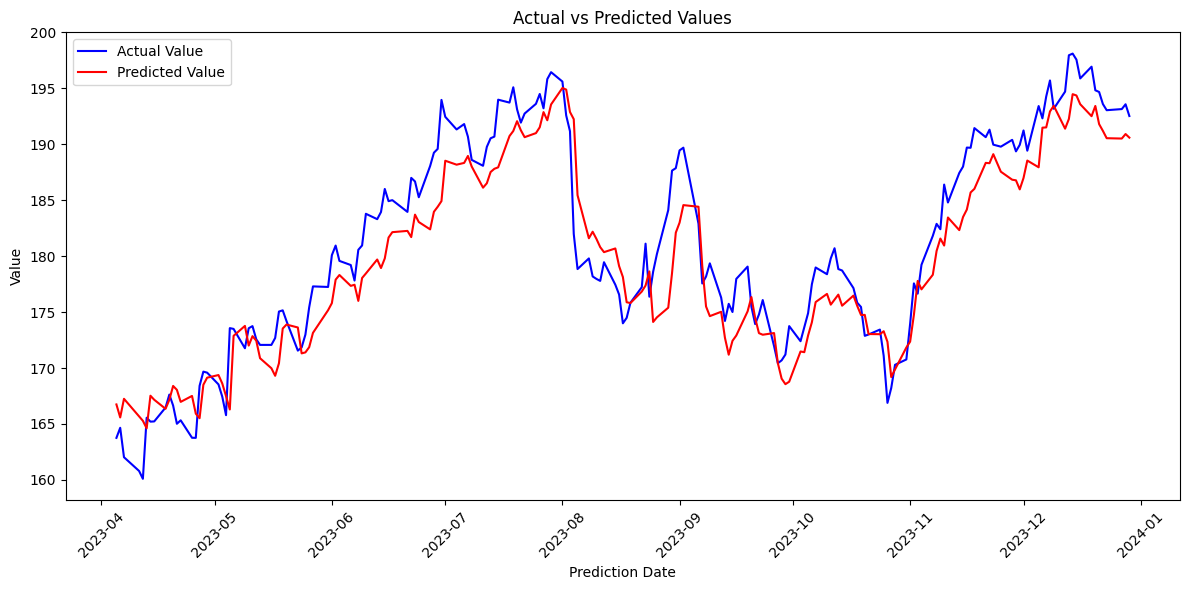

In [287]:
import matplotlib.pyplot as plt

# Extract the first predicted and first actual values along with the prediction dates
prediction_dates = results_df['prediction_date']
first_predicted_values = [pred[0] for pred in results_df['predicted_values']]
first_actual_values = [actual[0] for actual in results_df['actual_values']]

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the actual values
plt.plot(prediction_dates, first_actual_values, label='Actual Value', color='blue', )

# Plot the predicted values
plt.plot(prediction_dates, first_predicted_values, label='Predicted Value', color='red',)

# Adding title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Prediction Date')
plt.ylabel('Value')

# Add a legend
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [288]:
import numpy as np
results_df['first_predicted_value'] = results_df['predicted_values'].apply(lambda x: x[0][0] if isinstance(x, (list, np.ndarray)) else x)
results_df['first_actual_value'] = results_df['actual_values'].apply(lambda x: x[0])

# Create a new DataFrame with the necessary columns
context_results_df = pd.DataFrame({
    'y_actual': results_df['first_actual_value'],
    'raw_forecast': results_df['first_predicted_value'],
    'prediction_date': results_df['prediction_date']
})
context_results_df


,y_actual,raw_forecast,prediction_date
0,163.759995,166.748138,2023-04-05
1,164.660004,165.585205,2023-04-06
2,162.029999,167.252029,2023-04-07
3,160.800003,165.674774,2023-04-11
4,160.100006,165.286011,2023-04-12
...,...,...,...
181,193.600006,191.201721,2023-12-22
182,193.050003,190.546982,2023-12-23
183,193.149994,190.516144,2023-12-27
184,193.580002,190.919662,2023-12-28


In [289]:
context_results_df=context_results_df[:-1]
context_results_df

,y_actual,raw_forecast,prediction_date
0,163.759995,166.748138,2023-04-05
1,164.660004,165.585205,2023-04-06
2,162.029999,167.252029,2023-04-07
3,160.800003,165.674774,2023-04-11
4,160.100006,165.286011,2023-04-12
...,...,...,...
180,194.679993,191.806015,2023-12-21
181,193.600006,191.201721,2023-12-22
182,193.050003,190.546982,2023-12-23
183,193.149994,190.516144,2023-12-27


In [290]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score


# Define the calculation functions (same as before)
def calculate_mse(context_results_df):
    return mean_squared_error(context_results_df['y_actual'], context_results_df['raw_forecast'])

def calculate_accuracy(context_results_df):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df)):
        actual_today = context_results_df['y_actual'].iloc[i]
        predicted_today = context_results_df['raw_forecast'].iloc[i]
        actual_yesterday = context_results_df['y_actual'].iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df)):
        today_price = context_results_df['y_actual'].iloc[i]
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['raw_forecast'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df)):
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        yesterday_predicted_today_price = context_results_df['raw_forecast'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_results_for_context_len(context_len, context_results_df):
    # Use the provided DataFrame directly
    mse_value = calculate_mse(context_results_df)
    accuracy_value = calculate_accuracy(context_results_df)
    profit = calculate_profit(context_results_df)
    direction_accuracy = calculate_direction_accuracy(context_results_df)
    actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df)
    direction_profit = calculate_direction_profit(context_results_df)

    # Compile the results into a DataFrame
    result = {
        'context_len': context_len,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit
    }

    return pd.DataFrame([result])

# Calculate the results for the provided context_results_df
final_result_df = calculate_results_for_context_len(context_length, context_results_df)
print(final_result_df)


   context_len        mse  accuracy  direction_accuracy  \
0         1024  11.656839  0.467391            0.521739   

   actual_direction_accuracy  direction_profit    profit  
0                   0.472826         14.487743  5.503064  


In [291]:
def calculate_buy_and_hold_profit(context_results_df, initial_capital=100):
    """
    Calculate the profit from a buy-and-hold strategy.

    Args:
    - context_results_df (DataFrame): DataFrame containing actual prices.
    - initial_capital (float): The starting amount of money.

    Returns:
    - float: The profit from a buy-and-hold strategy.
    """
    # Buy at the first available price
    first_price = context_results_df['y_actual'].iloc[0]

    # Sell at the last available price
    last_price = context_results_df['y_actual'].iloc[-1]

    # Calculate the number of shares bought initially
    shares = initial_capital / first_price

    # Final capital after selling all shares at the last price
    final_capital = shares * last_price

    # Profit is the final capital minus the initial capital
    profit = final_capital - initial_capital

    return profit

# Assuming `context_results_df` is already prepared as in the previous code
buy_and_hold_profit = calculate_buy_and_hold_profit(context_results_df)
print(f"Buy and Hold Profit: {buy_and_hold_profit}")


Buy and Hold Profit: 18.209580071141218
